## Install the package dependencies before running this notebook

In [ ]:
# import sys
# !{sys.executable} -m pip install torch_lr_finder
%pip install pytorch-lightning

In [2]:
import numpy 
import csv
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pack_padded_sequence
from torch.utils.data import Dataset, DataLoader
import os, os.path 
import pickle
from glob import glob
import seaborn as sns
import matplotlib.pylab as plt
torch.set_default_dtype(torch.float32)
"""
    number of trajectories in each city
    # austin --  train: 43041 test: 6325 
    # miami -- train: 55029 test:7971
    # pittsburgh -- train: 43544 test: 6361
    # dearborn -- train: 24465 test: 3671
    # washington-dc -- train: 25744 test: 3829
    # palo-alto -- train:  11993 test:1686

    trajectories sampled at 10HZ rate, input 5 seconds, output 6 seconds
    
"""

'\n    number of trajectories in each city\n    # austin --  train: 43041 test: 6325 \n    # miami -- train: 55029 test:7971\n    # pittsburgh -- train: 43544 test: 6361\n    # dearborn -- train: 24465 test: 3671\n    # washington-dc -- train: 25744 test: 3829\n    # palo-alto -- train:  11993 test:1686\n\n    trajectories sampled at 10HZ rate, input 5 seconds, output 6 seconds\n    \n'

## Check GPU Availability

In [3]:
# print(torch.mps.is_available())
# print(torch.mps.device_count())
# print(torch.mps.get_device_name(0))
device = torch.device('mps' if torch.cuda.is_available() else 'cpu')

In [4]:
os.getcwd()

'/Users/lianglin/Desktop/CSE151/argo2'

## Create a Torch.Dataset class for the training dataset

In [5]:
from glob import glob
import pickle
import numpy as np

ROOT_PATH = os.getcwd() + "/"

cities = ["austin", "miami", "pittsburgh", "dearborn", "washington-dc", "palo-alto"]
splits = ["train", "test"]

# Get data as numpy array.
# If it's train data, return the input and output (for validation)
# If it's test data, return only the input (for prediction)
def get_city_trajectories(city="palo-alto", split="train", normalized=False):
    
    outputs = None
    inputs = None
    
    if split == "all_train":
        f_in = ROOT_PATH + "train" + "/" + city + "_inputs"
        inputs = pickle.load(open(f_in, "rb"))
        inputs = np.asarray(inputs)
    
        f_out = ROOT_PATH + "train" + "/" + city + "_outputs"
        outputs = pickle.load(open(f_out, "rb"))
        outputs = np.asarray(outputs)
    
    elif split=="train":
        
        f_in = ROOT_PATH + split + "/" + city + "_inputs"
        inputs = pickle.load(open(f_in, "rb"))
        inputs = np.asarray(inputs)
    
        f_out = ROOT_PATH + split + "/" + city + "_outputs"
        outputs = pickle.load(open(f_out, "rb"))
        
        length = len(inputs)
        split_size = int(length * 0.8)
        
        outputs = np.asarray(outputs)[:split_size]
        inputs = inputs[:split_size]
        
    elif split=="val":
    
        f_in = ROOT_PATH + "train" + "/" + city + "_inputs"
        inputs = pickle.load(open(f_in, "rb"))
        inputs = np.asarray(inputs)
    
        f_out = ROOT_PATH + "train" + "/" + city + "_outputs"
        outputs = pickle.load(open(f_out, "rb"))
        
        length = len(inputs)
        split_size = int(length * 0.8)
        print(split_size)
        
        outputs = np.asarray(outputs)[split_size:]
        inputs = inputs[split_size:]
        
    else:
        f_in = ROOT_PATH + split + "/" + city + "_inputs"
        inputs = pickle.load(open(f_in, "rb"))
        inputs = np.asarray(inputs)
    
    if normalized:
        if split=='all_train' or split=='train' or split=='val':
            global_min = np.min(inputs, axis = (0,1), keepdims = True)
            global_max = np.max(inputs, axis = (0,1), keepdims = True)
            normal_inputs = (inputs - global_min)/(global_max - global_min)
            normal_targets = (outputs - global_min)/(global_max - global_min)
            return normal_inputs, normal_targets
        else:
            global_min = np.min(inputs, axis = (0,1), keepdims = True)
            global_max = np.max(inputs, axis = (0,1), keepdims = True)
            normal_inputs = (inputs - global_min)/(global_max - global_min)
            return normal_inputs, outputs

    return inputs, outputs


class ArgoverseDataset(Dataset):
    """Dataset class for Argoverse"""
    def __init__(self, city: str, split:str, transform=None):
        super(ArgoverseDataset, self).__init__()
        self.city = city
        self.split = split
        self.transform = transform

        self.inputs, self.outputs = get_city_trajectories(city=city, split=split, normalized=True)
        print(self.inputs.shape)

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        
        if self.split == "train" or self.split == "val" or self.split == "all_train":
            data = (self.inputs[idx], self.outputs[idx])
        else:
            data = self.inputs[idx]
            
        if self.transform:
            data = self.transform(data)

        return data
    
    def get_std(self):
        return torch.std(self.inputs, unbiased=False)
    
    def get_mean(self):
        return torch.mean(self.inputs)

# intialize a dataset
city = 'palo-alto'
all_train_dataset = ArgoverseDataset(city = city, split = "all_train")
train_dataset  = ArgoverseDataset(city = city, split = "train")
val_dataset = ArgoverseDataset(city = city, split = "val")

(11993, 50, 2)
(9594, 50, 2)
9594
(2399, 50, 2)


In [68]:
print(len(all_train_dataset))
print(len(val_dataset))

11993
2399


## Data Visualization

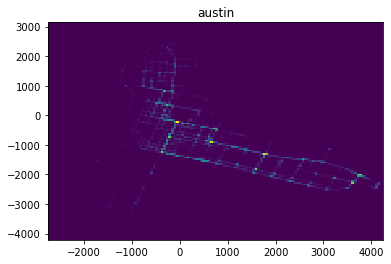

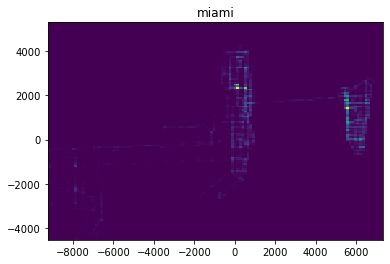

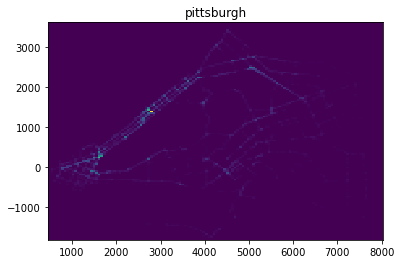

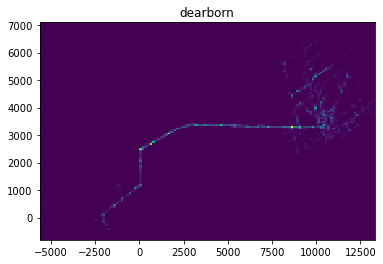

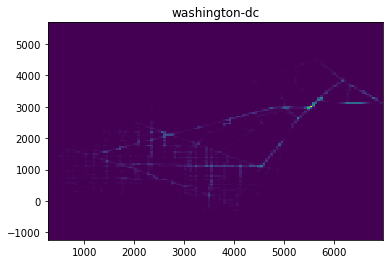

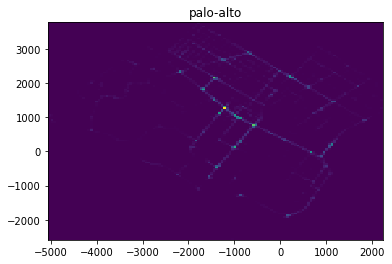

In [36]:
def create_heat_map(mode='Input', split='train'):
    for city in cities:
        x = []
        y = []
        inputs, outputs = get_city_trajectories(city=city)
        if (mode == 'Input'):
            inputs = inputs.reshape(len(inputs) * len(inputs[0]), 2)
            inputs = np.array(inputs)
            city_x = [inputs[i][0] for i in range(len(inputs))]
            city_y = [inputs[i][1] for i in range(len(inputs))]
            x = np.concatenate((x, city_x))
            y = np.concatenate((y, city_y))
        elif mode == 'Output':
            outputs = outputs.reshape(len(outputs) * len(outputs[0]), 2)
            outputs = np.array(outputs)
            city_x = [outputs[i][0] for i in range(len(outputs))]
            city_y = [outputs[i][1] for i in range(len(outputs))]
            x = np.concatenate((x, city_x))
            y = np.concatenate((y, city_y))
        else:
            inputs = inputs.reshape(len(inputs) * len(inputs[0]), 2)
            inputs = np.array(inputs)
            city_x_in = [inputs[i][0] for i in range(len(inputs))]
            city_y_in = [inputs[i][1] for i in range(len(inputs))]
            outputs = outputs.reshape(len(outputs) * len(outputs[0]), 2)
            outputs = np.array(outputs)
            city_x_out = [outputs[i][0] for i in range(len(outputs))]
            city_y_out = [outputs[i][1] for i in range(len(outputs))]
            x = np.concatenate((x, city_x_in))
            x = np.concatenate((x, city_x_out))
            y = np.concatenate((y, city_y_in))
            y = np.concatenate((y, city_y_out))
        plt.title(city)
        plt.hist2d(x,y,bins=(128, 128))
        plt.show()


create_heat_map(mode="All")

## Models

In [ ]:
# Linear Regression
class LR(torch.nn.Module):
    def __init__(self, input_dim, out_dim):
        super(LR, self).__init__()
        """
        the __init__() method that defines the layers and other components
        """ 
        self.model = nn.Linear(input_dim, out_dim) # input_dim = input_length*2
        
    def forward(self, x, output_steps): 
        """
        the forward function is where computatioin gets done
        """
        x = x.reshape(x.shape[0], -1)
        
        outputs = []
        for i in range(output_steps):
            out = self.model(x)    
            outputs.append(out)
            x = torch.cat([x[:,2:],  out], dim = 1)
            
        outputs = torch.cat(outputs, dim = 1)
        return outputs.reshape(outputs.shape[0], output_steps, 2)

In [ ]:
class LSTM(nn.Module):
    
    def __init__(self, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(self.input_size, self.hidden_size, self.num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 2)
    
    def forward(self, x, hidden, cell):
        out, (hidden, cell) = self.lstm(x, (hidden, cell))
        pred = self.fc(torch.squeeze(hidden, 0))
        out = out.to(device)
        hidden = hidden.to(device)
        cell = cell.to(device)
        pred = pred.to(device)
        return out, (hidden, cell), pred
    
    def init_hidden(self, batch_size):
        hidden = torch.zeros(self.num_layers, batch_size, self.hidden_size)
        cell = torch.zeros(self.num_layers, batch_size, self.hidden_size)
        hidden = hidden.to(device)
        cell = cell.to(device)
        return hidden, cell

In [51]:
class EncoderModel(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(100, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, 32)
        ).to(device)
        
        self.decoder = nn.Sequential(
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 120),
            nn.ReLU(),
            nn.Linear(120, 120)
        ).to(device)
        
    def forward(self, x):
        x = x.reshape(-1, 100).float()
        x = self.encoder(x)
        x = self.decoder(x)
        x = x.reshape(-1, 60, 2)
        x = x.to(device)
        return x

In [26]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, dropout_rate):
        
        super(Encoder, self).__init__()

        self.lstm = nn.LSTM(input_size = input_dim, 
                            hidden_size = hidden_dim, 
                            num_layers= num_layers, 
                            dropout = dropout_rate, 
                            batch_first = True)
        
        
    def forward(self, source):
        
        # hidden = (h, c)
        # h, c: num_layers x bz x  hid_dim
        # outputs: bz x input_length x hid_dim
        outputs, hidden = self.lstm(source)
        
        return outputs, hidden
    
class AttnDecoder(nn.Module):
    def __init__(self, output_dim, hidden_dim, num_layers, dropout_rate):

        super(AttnDecoder, self).__init__()

        # Learn the attention scores
        self.attn = nn.Linear(hidden_dim + output_dim, 50)
        
        # Learn the final input to the decoder 
        self.attn_combine = nn.Linear(hidden_dim + output_dim, hidden_dim)
        
        # Decoder LSTM
        self.lstm = nn.LSTM(input_size = hidden_dim, 
                            hidden_size = hidden_dim, 
                            num_layers= num_layers, 
                            dropout = dropout_rate, 
                            batch_first = True)
        
        self.output_layer = nn.Linear(hidden_dim, output_dim)
      
    def forward(self, x, hidden, encoder_outputs):
        
        h = hidden[0]
        h = h.transpose(0,1).reshape(h.shape[1], -1)
        
        # Compute Attention Scores
        attn_weights = F.softmax(self.attn(torch.cat([x, h], 1)), dim =1)
        
        # Calculate weighted sum of encoder hidden states     
        attn_applied = torch.einsum("bl,blh->bh", attn_weights, encoder_outputs)
        
        x = torch.cat((x, attn_applied), dim = 1)
        x = self.attn_combine(x).unsqueeze(1)
        x = F.relu(x)
        
        output, decoder_hidden= self.lstm(x, hidden)  
        prediction = self.output_layer(output.float())
        
        return prediction.squeeze(1), decoder_hidden
    
class Seq2Seq(nn.Module):
    def __init__(self, input_dim = 2, output_dim = 2, hidden_dim = 128, num_layers = 1, dropout_rate = 0):
        
        super(Seq2Seq, self).__init__()
        self.encoder = Encoder(input_dim, hidden_dim, num_layers, dropout_rate)
        self.decoder = AttnDecoder(output_dim, hidden_dim, num_layers, dropout_rate)

    def forward(self, source, target_length):

        batch_size = source.size(0) 
        input_length = source.size(1) 
        
        encoder_outputs, concat_hidden = self.encoder(source)
        
        # the last encoder hidden state is used as initial hidden state of the decoder
        decoder_hidden = concat_hidden
        # the first input to the decoder is last input position
        decoder_output = source[:,-1]
    
        
        outputs = torch.zeros(batch_size, target_length, 2)
        for t in range(target_length):    
            decoder_output, decoder_hidden = self.decoder(decoder_output, decoder_hidden, encoder_outputs)
            outputs[:,t] = decoder_output   
        return outputs
    


In [ ]:
# Will ensemble all together after the mid report due to time constraints
class generator:
    
    def __init__(self):
        pass
    
    def to_tensor(self, array):
        pass
    
    def get_batch(self):
        pass
    
    def generate(self):
        pass
    
    def train(self):
        pass

## Create a DataLoader class for training

In [11]:
batch_sz = 2  # batch size 
train_loader = DataLoader(all_train_dataset,batch_size=batch_sz)
val_loader = DataLoader(val_dataset,batch_size=batch_sz)

## Sample a batch of data and visualize 

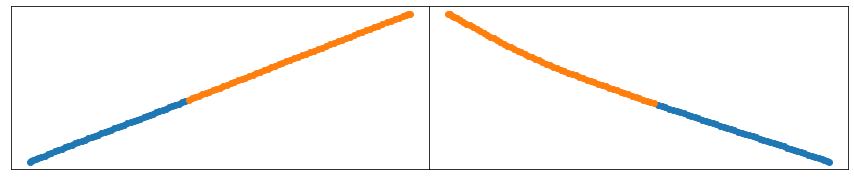

In [12]:
import matplotlib.pyplot as plt
import random

def show_sample_batch(sample_batch):
    """visualize the trajectory for a batch of samples"""
    inp, out = sample_batch
    batch_sz = inp.size(0)
    agent_sz = inp.size(1)
    
    fig, axs = plt.subplots(1,batch_sz, figsize=(15, 3), facecolor='w', edgecolor='k')
    fig.subplots_adjust(hspace = .5, wspace=.001)
    axs = axs.ravel()   
    for i in range(batch_sz):
        axs[i].xaxis.set_ticks([])
        axs[i].yaxis.set_ticks([])
        
        # first two feature dimensions are (x,y) positions
        axs[i].scatter(inp[i,:,0], inp[i,:,1])
        axs[i].scatter(out[i,:,0], out[i,:,1])
        
for i_batch, sample_batch in enumerate(train_loader):
    inp, out = sample_batch
    show_sample_batch(sample_batch)
    break

## Training - Model 1: LSTM

In [ ]:
model = LSTM(2, 128, 1)
model = model.to(device)
criterion = nn.MSELoss()
model.zero_grad()
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
# hidden, cell = model.init_hidden(batch_size=batch_sz)

def new_input(input_tensor, pred):
    new_tensor = torch.zeros([4, 50, 2])
    for i in range(4):
        new_tensor[i,:49,:] = input_tensor[i,1:50,:]
        new_tensor[i][49] = pred[i]
    new_tensor = new_tensor.float()
    new_tensor = new_tensor.to(device)
    return new_tensor

for i_batch, sample_batch in enumerate(train_loader):
    inp, out = sample_batch
    if (len(inp) != 4):
        break;
    inp = inp.float()
    out = out.float()
    inp = inp.to(device)
    out = out.to(device)
    """
    TODO:
      implement your Deep learning model
      implement training routine
    """
    hidden, cell = model.init_hidden(batch_size=batch_sz)
    loss = 0
    for i in range(60):
        output, (hidden, cell), pred = model(inp, hidden, cell)
        inp = new_input(inp, pred)
        loss += criterion(pred, out[:,i])
    print(loss)
    loss.backward()
    optimizer.step()
        
#     show_sample_batch(sample_batch)
#     break

## Training - Model 2: Seq2Seq

In [70]:
df = pd.read_csv('sample_submission.csv', index_col='ID')
criterion = nn.MSELoss().to(device)

def run_model(city):
    
    model = EncoderModel()
    model = model.to(device)
    opt = torch.optim.Adam(model.parameters(), lr=1e-4)
    
    train_dataset = ArgoverseDataset(city = city, split = "all_train")
    train_loader = DataLoader(train_dataset, batch_size=batch_sz)
    global_std = train_dataset.get_std()
    global_mean = train_dataset.get_mean()
    
    for epoch in range(50):
        total_loss = 0
        for i_batch, sample_batch in enumerate(train_loader):
            inp, out = sample_batch
            inp = inp.float().to(device)
            out = out.float().to(device)
            preds = model(inp)
            preds = preds.float().to(device)
            preds = preds * global_std * global_mean
            loss = criterion(preds, out)

            opt.zero_grad()
            loss.backward()
            opt.step()

            total_loss += loss.item()
        print('city: {} epoch {}: loss = {}'.format(city, epoch, total_loss / len(train_dataset)))
    predict(city, model)
#     validate(model, city)
    
    
def predict(city, model):
    
    test_dataset  = ArgoverseDataset(city = city, split = "test")
    test_loader = DataLoader(test_dataset, batch_size=batch_sz)
    
    for i_batch, sample_batch in enumerate(test_loader):
        inp = sample_batch
        inp = inp.float().to(device)
        preds = model(inp)
        preds = preds * global_std * global_mean
        for i in range(len(preds[0])):
            for j in range(len(preds)):
                row = str(i_batch * batch_sz + j) + "_" + city
                x_col = "v" + str(2 * i)
                y_col = "v" + str(2 * i + 1)
                df.loc[row, x_col] = preds[j][i][0].item()
                df.loc[row, y_col] = preds[j][i][1].item()
    df.to_csv('sample_submission.csv')
    
def validate(model, city):
    total_loss = 0
    for i_batch, sample_batch in enumerate(val_loader):
        inp, out = sample_batch
        inp = inp.float().to(device)
        preds = model(inp)
        preds = preds.float().to(device)
        loss = criterion(preds, out)
        total_loss += loss.item()
    print('city: {} loss = {}'.format(city, total_loss / len(val_dataset)))
            
for city in cities:
    run_model(city)
# run_model("palo-alto")

TypeError: std() received an invalid combination of arguments - got (numpy.ndarray, unbiased=bool), but expected one of:
 * (Tensor input, tuple of ints dim, bool unbiased, bool keepdim, *, Tensor out)
 * (Tensor input, tuple of ints dim, *, int correction, bool keepdim, Tensor out)
 * (Tensor input, bool unbiased)
      didn't match because some of the arguments have invalid types: (!numpy.ndarray!, unbiased=bool)
 * (Tensor input, tuple of names dim, bool unbiased, bool keepdim, *, Tensor out)
 * (Tensor input, tuple of names dim, *, int correction, bool keepdim, Tensor out)


In [45]:
df = pd.read_csv('sample_submission.csv', index_col='ID')

def run_model(city):
    
    model = Seq2Seq()
    model = model.to(device)
    criterion = nn.MSELoss().to(device)
    opt = torch.optim.Adam(model.parameters(), lr=1e-4)
    
    train_dataset = ArgoverseDataset(city = city, split = "all_train")
    train_loader = DataLoader(train_dataset, batch_size=batch_sz)
    for epoch in range(20):
        total_loss = 0
        for i_batch, sample_batch in enumerate(train_loader):
            inp, out = sample_batch
            inp = inp.float().to(device)
            out = out.float().to(device)
            preds = model(inp, target_length=60)
            preds = preds.float().to(device)
            loss = criterion(preds, out)

            opt.zero_grad()
            loss.backward()
            opt.step()

            total_loss += loss.item()
        print('city: {} epoch {}: loss = {}'.format(city, epoch, total_loss / len(train_dataset)))
    predict(city, model)
#     random_validation(model)
    
    
def predict(city, model):
    
    test_dataset  = ArgoverseDataset(city = city, split = "test")
    test_loader = DataLoader(test_dataset, batch_size=batch_sz)
    
    for i_batch, sample_batch in enumerate(test_loader):
        inp = sample_batch
        inp = inp.float().to(device)
        preds = model(inp, target_length=60)
        for i in range(len(preds[0])):
            for j in range(len(preds)):
                row = str(i_batch * batch_sz + j) + "_" + city
                x_col = "v" + str(2 * i)
                y_col = "v" + str(2 * i + 1)
                df.loc[row, x_col] = preds[j][i][0].item()
                df.loc[row, y_col] = preds[j][i][1].item()
    df.to_csv('sample_submission.csv')
            
for city in cities:
    run_model(city)
# run_model("palo-alto")

city: austin epoch 0: loss = 2125.9310888127325
city: austin epoch 1: loss = 2124.2303416879645
city: austin epoch 2: loss = 2119.941163016961
city: austin epoch 3: loss = 2116.7431640625


KeyboardInterrupt: 

## Make Predictions

In [ ]:
val_loader = DataLoader(val_dataset,batch_size=batch_sz)
val_loss = 0

for i_batch, sample_batch in enumerate(val_loader):
    inp, out = sample_batch
    preds = model(inp)
    loss = ((preds - out) ** 2).sum()

    val_loss += loss.item()
print('loss = {}'.format(total_loss / len(val_dataset)))

In [ ]:
city = 'palo-alto' 
split = 'test'
test_dataset  = ArgoverseDataset(city = city, split = split)
test_loader = DataLoader(test_dataset, batch_size=4)
df = pd.read_csv('sample_submission.csv', index_col='ID')
# df.loc['1685_palo-alto', 'v0'] = 1000
# df.to_csv('sample_submission.csv')

In [ ]:
def forcast_trajectory():
    for i_batch, sample_batch in enumerate(test_loader):
        inp = sample_batch
        if (len(inp) != 4):
            continue;
        inp = inp.float()
        for i in range(60):
            _, __, pred = model(inp, hidden, cell)
            inp = new_input(inp, pred)
            for j in range(batch_sz):
                row = str(i_batch * 4 + j) + "_" + city
                count = 0
                x_col = "v" + str(2 * i)
                y_col = "v" + str(2 * i + 1)
                df.loc[row, x_col] = pred[j][0].item()
                df.loc[row, y_col] = pred[j][1].item()
    df.to_csv('sample_submission.csv')

In [ ]:
forcast_trajectory()